#Apply image segmentation techniques

#Apply a threshold

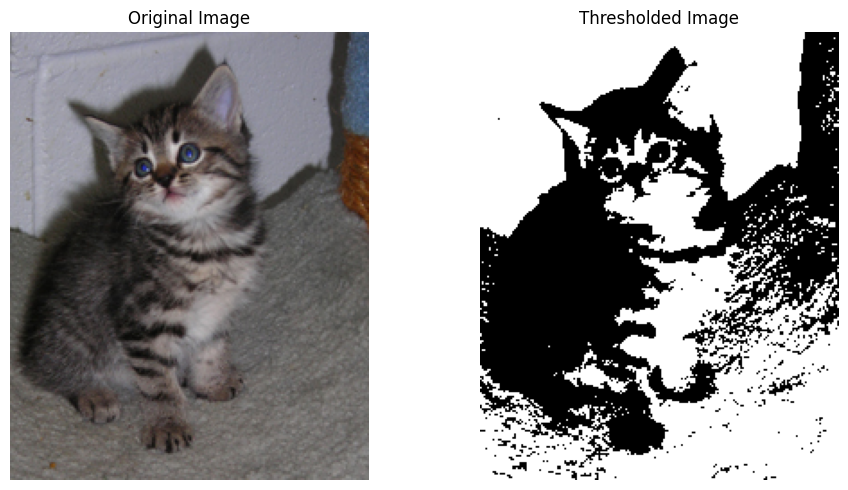

In [5]:
from matplotlib import pyplot as plt
import cv2

# Load the uploaded image
image_path = '/content/1073.jpg'
image = cv2.imread(image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


# We use Otsu's thresholding which automatically finds the optimal threshold value
_, thresholded_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Display the original and thresholded images side by side for comparison
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(thresholded_image, cmap='gray')
plt.title('Thresholded Image')
plt.axis('off')

plt.tight_layout()
plt.show()


# Apply edge detection using the Canny edge detector

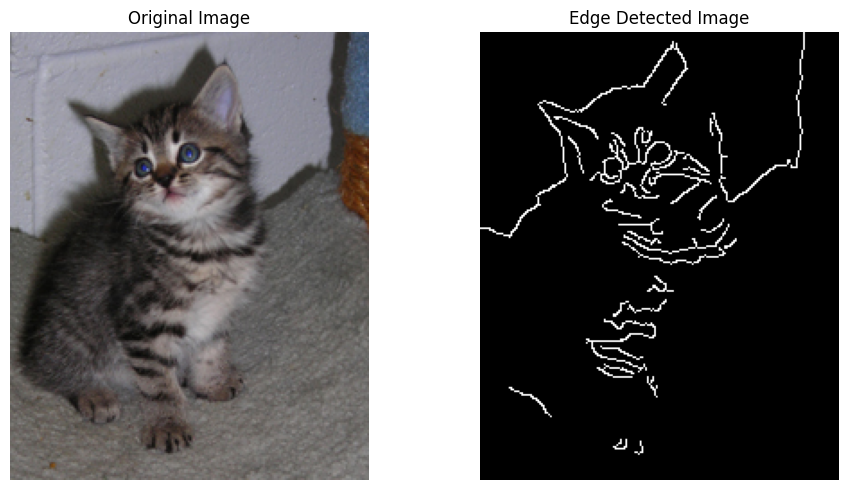

In [6]:
# First, we might want to apply a Gaussian blur to reduce noise which helps in edge detection
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Now apply the Canny edge detector
edges = cv2.Canny(blurred_image, threshold1=100, threshold2=200)

# Display the original and edge-detected images side by side for comparison
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detected Image')
plt.axis('off')

plt.tight_layout()
plt.show()


#Region-based Segmentation

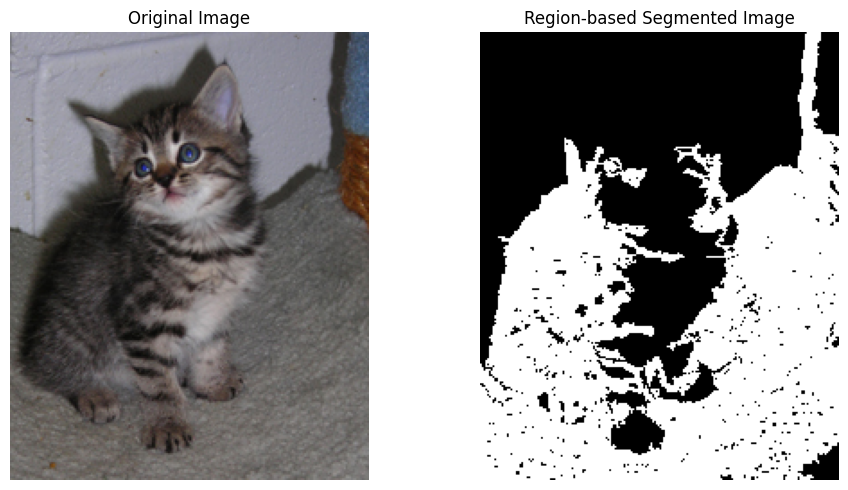

In [7]:
import numpy as np

# Function to perform region-based segmentation using a seed point
def region_growing(img, seed):
    # Parameters for region growing
    neighbors = [(0, 1), (1, 0), (-1, 0), (0, -1)] # 4-connectivity
    threshold = 20  # Threshold of intensity difference
    segmented_image = np.zeros_like(img)
    rows, cols = img.shape
    mean_val = float(img[seed])

    # List to keep track of region pixel coords
    region = [seed]

    # Grow the region
    while len(region) > 0:
        r, c = region.pop(0)
        # Skip if the pixel is already segmented
        if segmented_image[r, c] == 1:
            continue
        # Segment pixel
        segmented_image[r, c] = 1

        # Check the neighbors
        for dx, dy in neighbors:
            rx, ry = r + dx, c + dy
            if (0 <= rx < rows) and (0 <= ry < cols):
                # Check if neighbor should be added to region
                if abs(int(img[rx, ry]) - mean_val) < threshold:
                    mean_val = (mean_val * len(region) + float(img[rx, ry])) / (len(region) + 1) # Update mean
                    region.append((rx, ry))

    return segmented_image

# Apply region growing
# We need a seed point, let's choose one around the middle of the kitten
seed_point = (int(gray_image.shape[0] / 2), int(gray_image.shape[1] / 2))
segmented_img = region_growing(gray_image, seed_point)

# Display the result
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_img, cmap='gray')
plt.title('Region-based Segmented Image')
plt.axis('off')

plt.tight_layout()
plt.show()


#Clustering


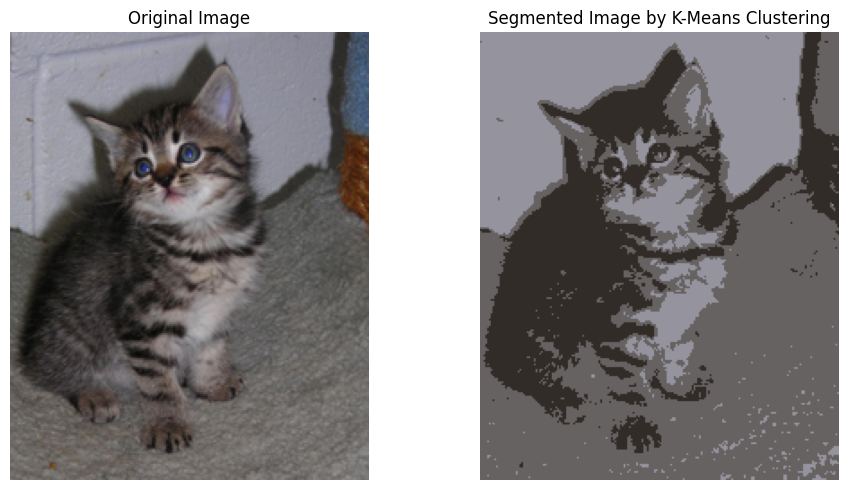

In [8]:
from sklearn.cluster import KMeans

# Reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = image.reshape((-1, 3))
# Convert to float
pixel_values = np.float32(pixel_values)

# Define criteria and apply kmeans()
# The criteria (type, max_iter, epsilon):
# - type of termination criteria : cv2.TERM_CRITERIA_EPS - stop the algorithm iteration if specified accuracy, epsilon, is reached.
# - max_iter - the maximum number of iterations.
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

# Number of clusters (K)
k = 3
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert back to 8 bit values
centers = np.uint8(centers)

# Flatten the labels array
labels = labels.flatten()

# Convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

# Reshape back to the original image dimension
segmented_image = segmented_image.reshape(image.shape)
# Convert from BGR to RGB for displaying
segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)

# Show the image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title('Segmented Image by K-Means Clustering')
plt.axis('off')

plt.tight_layout()
plt.show()


# Apply the Watershed algorithm

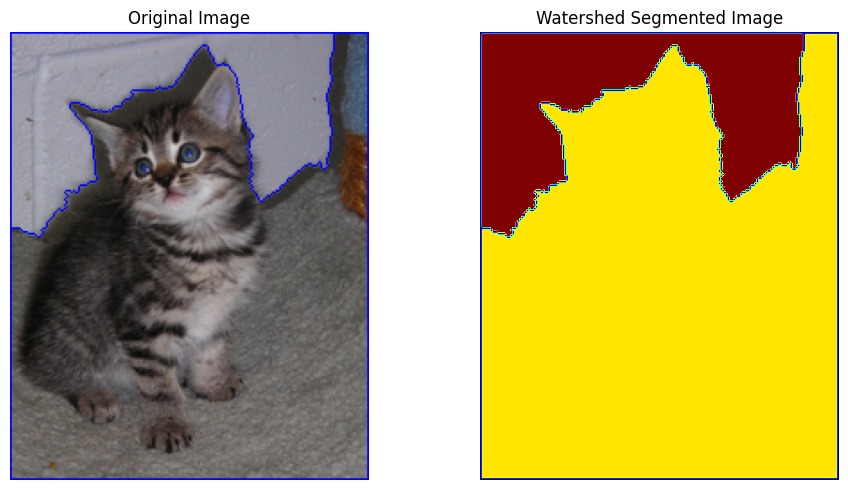

In [9]:

# First, we need to define the sure background area by dilating the thresholded image
kernel = np.ones((3,3),np.uint8)
sure_bg = cv2.dilate(thresholded_image,kernel,iterations=3)

# Finding sure foreground area using the distance transform method
dist_transform = cv2.distanceTransform(thresholded_image,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region by subtracting sure foreground from sure background
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

# Apply the watershed algorithm
markers = cv2.watershed(image,markers)
image[markers == -1] = [255,0,0]

# Display the result
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(markers, cmap='jet')
plt.title('Watershed Segmented Image')
plt.axis('off')

plt.tight_layout()
plt.show()
